# **LONG STEPS in GRADIENT DESCENT METHODS**

## **Install**

### Firedrake

In [1]:
try:
    import google.colab  # noqa: F401
except ImportError:
    from firedrake import *
else:
    try:
        from firedrake import *
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh"
        !bash "/tmp/firedrake-install.sh"
        from firedrake import *

--2025-10-16 21:42:24--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-10-16 21:42:24 (53.5 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a082

### Other

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

## **General functions**

### Constrained optimisation

In [47]:
def constrained_optimisation(nx=2**7, degree=1, gamma=2**32, max_iters=2**6, energy_exact=None, h="newton"):
    # UFL-ify constants
    gamma = Constant(gamma)

    # Mesh
    mesh = UnitSquareMesh(nx, nx, quadrilateral=True)
    V = FunctionSpace(mesh, "Q", degree)

    # Constraint function f(x, y): circular bump
    x, y = SpatialCoordinate(mesh)
    cylinders = (
        ((0.4, 0.6), 0.3, 1.0),
        ((0.6, 0.4), 0.2, 0.8),
    )
    f = conditional((x - cylinders[0][0][0])**2 + (y - cylinders[0][0][1])**2 <= cylinders[0][1]**2, cylinders[0][2],
        conditional((x - cylinders[1][0][0])**2 + (y - cylinders[1][0][1])**2 <= cylinders[1][1]**2, cylinders[1][2],
        0.0
    ))

    # Functions
    u = Function(V)
    u_ = Function(V)
    v = TestFunction(V)

    # BCs
    bcs = DirichletBC(V, 0.0, "on_boundary")

    # Energy
    h1_seminorm = 0.5 * inner(grad(u_), grad(u_)) * dx
    constraint_viol = 0.5 * conditional(lt(u_, f), (u_ - f)**2, 0) * dx
    E = h1_seminorm + gamma * constraint_viol

    # Check method and normalise input
    use_newton = isinstance(h, str) and h.lower() == "newton"
    if not use_newton:
        if np.isscalar(h):
            h = [float(h)]
        elif isinstance(h, (list, tuple, np.ndarray)):
            h = list(np.array(h, dtype=float).ravel())
        else:
            raise ValueError("h must be 'newton', a scalar, or an array-like of step sizes")
        h_len = len(h)
        if h_len == 0:
            raise ValueError("Step sequence h must be non-empty")
        h_ = Constant(h[0])

    # Residual
    if use_newton:
        F = (
            inner(grad(u), grad(v))
          + gamma * conditional(lt(u_, f), (u - f) * v, 0)
        ) * dx
    else:
        h1_norm = (
            inner(grad(u - u_), grad(v))
          + gamma * inner(u - u_, v)
        ) * dx
        E_prime = (
            inner(grad(u_), grad(v))
          + gamma * conditional(lt(u_, f), (u_ - f) * v, 0)
        ) * dx
        F = h1_norm + h_ * E_prime

    # Solve loop
    energy = assemble(E)
    energies = [energy]
    print(GREEN % f"Energy: {energy}")
    for i in range(max_iters):
        if use_newton:
            print(BLUE % f"Newton iterate {i+1}...")
        elif h_len == 1:
            print(BLUE % f"GD iterate {i+1}...")
        else:
            print(BLUE % f"GD iterate {i+1}, step size {h[i % h_len]}...")
            h_.assign(h[i % h_len])
        solve(F == 0, u, bcs)
        u_.assign(u)
        energy = assemble(E)
        energies += [energy]
        print(GREEN % f"Energy: {energy}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

    # Left: log energy error convergence
    energy_errors = [abs(energy - energy_exact) for energy in energies]

    if use_newton:
        ax1.semilogy(range(1, len(energy_errors)), energy_errors[1:], marker='o')
    else:
        ax1.loglog(range(1, len(energy_errors)), energy_errors[1:], marker='o')
    ax1.set_xlabel("Newton iterate")
    ax1.set_title("Energy errors")
    ax1.grid(True, which="both", ls="--", alpha=0.6)

    # Right: contour plot
    tpc = tripcolor(u, axes=ax2)
    # Create contour lines
    tricontour(u, levels=10, colors='w', linewidths=1.0, axes=ax2)
    ax2.set_aspect('equal')
    ax2.set_title("Contour plot")
    fig.colorbar(tpc, ax=ax2, orientation='vertical')
    for (center, width, _) in cylinders:
        circ = Circle(center, width, fill=False, color='k', linestyle='-', linewidth=2.0)
        ax2.add_patch(circ)

    plt.tight_layout()
    plt.show()

### Eikonal equation

In [52]:
def eikonal(nx=2**7, degree=1, gamma=2**32, max_iters=2**6, energy_exact=None, h="newton"):
    # UFL-ify constants
    gamma = Constant(gamma)

    # Mesh
    mesh = UnitSquareMesh(nx, nx, quadrilateral=True)
    V = FunctionSpace(mesh, "Q", degree)

    # Functions
    u = Function(V)
    x, y = SpatialCoordinate(mesh); u.interpolate(0.5*sin(pi*x)*sin(pi*y))
    u_ = Function(V)
    v = TestFunction(V)

    # BCs
    bcs = DirichletBC(V, 0.0, "on_boundary")

    # Energy
    l2_norm = 0.5 * inner(u, u) * dx
    grad_norm = lambda u_ref : conditional(
        gt(dot(grad(u_ref), grad(u_ref))**0.5, 1e-5),
        dot(grad(u_ref), grad(u_ref))**0.5,
        1e-5
    )
    grad_normalised = lambda u_ref : conditional(
        gt(dot(grad(u_ref), grad(u_ref))**0.5, 1e-5),
        grad(u_ref) / dot(grad(u_ref), grad(u_ref))**0.5,
        as_vector([1, 0])
    )
    constraint_viol = 0.5 * conditional(gt(grad_norm(u), 1), (grad_norm(u) - 1)**2, 0) * dx
    E = - l2_norm + gamma * constraint_viol

    # Check method and normalise input
    use_newton = isinstance(h, str) and h.lower() == "newton"
    use_boris = isinstance(h, str) and h.lower() == "boris"
    if use_boris:
        fibonacci = (2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597)
        h_boris = lambda i : 1/sin((1 + sqrt(5))/2 * pi * i)**2
        h_ = Constant(h_boris(1))
    elif not use_newton:
        if np.isscalar(h):
            h = [float(h)]
        elif isinstance(h, (list, tuple, np.ndarray)):
            h = list(np.array(h, dtype=float).ravel())
        else:
            raise ValueError("h must be 'newton', a scalar, or an array-like of step sizes")
        h_len = len(h)
        if h_len == 0:
            raise ValueError("Step sequence h must be non-empty")
        h_ = Constant(h[0])

    # Residual
    if use_newton:
        F = (
          - inner(u, v)
          + gamma * conditional(gt(grad_norm(u_), 1), (grad_norm(u_) - 1) * dot(grad_normalised(u_), grad(v)), 0)
          + gamma * conditional(gt(grad_norm(u_), 1), 1 / grad_norm(u_) * dot(grad_normalised(u_), grad(u - u_)) * dot(grad_normalised(u_), grad(v)), 0)
          + gamma * conditional(gt(grad_norm(u_), 1), (grad_norm(u_) - 1) / grad_norm(u_) * dot(grad(u - u_), grad(v)), 0)
        ) * dx
    else:
        h1_norm = gamma * (
            inner(grad(u - u_), grad(v))
          + inner(u - u_, v)
        ) * dx
        E_prime = (
          - inner(u_, v)
          + gamma * conditional(gt(grad_norm(u_), 1), (grad_norm(u_) - 1) * dot(grad_normalised(u_), grad(v)), 0)
        ) * dx
        F = h1_norm + h_ * E_prime

    # Solve loop
    energy = assemble(E)
    energies = [energy]
    print(GREEN % f"Energy: {energy}")
    if use_boris:
        energy_threshold = energies[-1]
        print(RED % f"Setting initial energy threshold: {energy_threshold}")
        j = 1
    for i in range(max_iters):
        u_.assign(u)
        if use_newton:
            print(BLUE % f"Newton iterate {i+1}...")
        elif use_boris:
            print(BLUE % f"Boris iterate {i+1}, step size {h_boris(j)}...")
            h_.assign(h_boris(j))
            j += 1
        elif h_len == 1:
            print(BLUE % f"GD iterate {i+1}...")
        else:
            print(BLUE % f"GD iterate {i+1}, step size {h[i % h_len]}...")
            h_.assign(h[i % h_len])
        solve(F == 0, u, bcs)
        energy = assemble(E)
        print(GREEN % f"Energy: {energy}")
        if use_boris and energy >= energy_threshold:
            energy_threshold = energies[-1]
            print(RED % f"Energy exceeded threshold. Setting new threshold: {energy_threshold}. Resetting cycle.")
            j = 1
            h_.assign(h_boris(j))
            j += 1
            solve(F == 0, u, bcs)
            energy = assemble(E)
            print(GREEN % f"Energy: {energy}")
        energies += [energy]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

    # Left: log energy error convergence
    energy_errors = [abs(energy - energy_exact) for energy in energies]

    if use_newton:
        ax1.semilogy(range(1, len(energy_errors)), energy_errors[1:], marker='o')
    else:
        ax1.loglog(range(1, len(energy_errors)), energy_errors[1:], marker='o')
    ax1.set_xlabel("Newton iterate")
    ax1.set_title("Energy errors")
    ax1.grid(True, which="both", ls="--", alpha=0.6)

    # Right: contour plot
    tpc = tripcolor(u, axes=ax2)
    # Create contour lines
    tricontour(u, levels=10, colors='w', linewidths=1.0, axes=ax2)
    ax2.set_aspect('equal')
    ax2.set_title("Contour plot")
    fig.colorbar(tpc, ax=ax2, orientation='vertical')

    plt.tight_layout()
    plt.show()

### Gradient descent

In [5]:
def quad(x, A):
    return 1/2 * np.dot(x, A @ x)

def grad_quad(x, A):
    return A @ x

def gd_quad(x0=None, A=np.diag([1.0, 5.0]), h="linesearch", n_steps=20):
    """
    Gradient descent on quadratic 1/2 x^T A x.
    Args:
      x0: initial point (shape (2,) for 2D)
      A: SPD matrix
      h:
        - "cg": conjugate gradient (CG)
        - "linesearch": exact line search step each iteration
        - scalar: fixed step size normalized by 1/L
        - list/tuple/np.ndarray: periodic sequence of normalized step sizes
      n_steps: number of iterations
    Returns:
      path: (N+1, d) array of iterates
      errors: (N+1,) array of energies 1/2 x^T A x
      norm_steps: (N,) array of normalized line-search steps lip * ||g||^2 / (g^T A g) when using linesearch, else None
    """
    if x0 is None:
        x0 = np.array([1 for _ in range(np.shape(A)[0])])
    path = [x0]
    errors = [quad(x0, A)]
    norm_steps = []
    x = x0

    # Detect linesearch or CG vs periodic/constant step
    use_cg = isinstance(h, str) and h.lower() == "cg"
    use_linesearch = isinstance(h, str) and h.lower() == "linesearch"
    if not use_linesearch and not use_cg:
        # Normalize h into a list of floats (periodic sequence)
        if np.isscalar(h):
            h = [float(h)]
        elif isinstance(h, (list, tuple, np.ndarray)):
            h = list(np.array(h, dtype=float).ravel())
        else:
            raise ValueError("h must be 'cg', 'linesearch', a scalar, or an array-like of step sizes")
        h_len = len(h)
        if h_len == 0:
            raise ValueError("Step sequence h must be non-empty")
        i = 0
    if use_cg:
        r = - grad_quad(x, A)
        p = r

    lip = np.linalg.norm(A, ord=2)

    for _ in range(n_steps):
        g = grad_quad(x, A)
        if use_cg:
            rr = np.dot(r, r)
            alpha = rr / quad(p, A) / 2
            x = x + alpha * p
            r = r - alpha * grad_quad(p, A)
            beta = np.dot(r, r) / rr
            p = r + beta * p
        elif use_linesearch:
            gTAg = 2 * quad(g, A)
            gg = np.dot(g, g)
            if gTAg == 0.0:
                gTAg = 1e-12  # avoid division by zero
            alpha = gg / gTAg
            # record normalized step size lip * alpha
            norm_steps.append(lip * alpha)
            x = x - alpha * g
        else:
            x = x - (h[i % h_len] / lip) * g
            i += 1
        path.append(x)
        errors.append(quad(x, A))

    path = np.array(path)
    errors = np.array(errors)
    if use_linesearch:
        norm_steps = np.array(norm_steps)
    else:
        norm_steps = None
    return path, errors, norm_steps

def gd_quad_plot2D(x0=None, A=np.diag([1.0, 5.0]), h="linesearch", n_steps=20, title=None):
    """
    Gradient descent with plotting if test is 2D.
    """
    # Run gradient descent
    path, errors, norm_steps = gd_quad(x0=x0, A=A, h=h, n_steps=n_steps)

    # Plot
    if isinstance(h, str) and h.lower() == "linesearch":
        _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4.5))
    else:
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
        ax3 = None
    # Contours
    x = np.linspace(-3, 3, 100); y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    # Vectorized evaluation of quadratic form over grid
    XY = np.stack([X.ravel(), Y.ravel()], axis=1)  # shape (N*N, 2)
    Z = (0.5 * np.einsum('ij,ij->i', XY, (XY @ A))).reshape(X.shape)
    ax1.contour(X, Y, Z, levels=20)
    ax1.plot(path[:,0], path[:,1], 'r--', label='GD path')
    ax1.plot(path[0,0], path[0,1], 'ro', label='initial', markersize=8)
    ax1.set_aspect('equal')
    ax1.set_title("Path of x" if title is None else title)
    ax1.legend()

    # Convergence
    ax2.semilogy(range(len(errors)), errors + 1e-15, 'b.-')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Energy')
    ax2.set_title('Convergence rate')

    # Normalized step sizes panel for line search
    if ax3 is not None and norm_steps is not None:
        ax3.plot(range(1, len(norm_steps)+1), norm_steps, 'g.-')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('h')
        ax3.set_title('Normalised line-search steps')
        ax3.grid(True, which="both", ls="--", alpha=0.6)

    plt.tight_layout()

    plt.show()

def gd_quad_plotND(x0=None, A=np.diag([1.0, 5.0]), h="linesearch", n_steps=20, title=None):
    """
    Gradient descent with plotting if test is ND.
    """
    # Run gradient descent
    _, errors, norm_steps = gd_quad(x0=x0, A=A, h=h, n_steps=n_steps)

    # Plot
    if isinstance(h, str) and h.lower() == "linesearch":
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
    else:
        _, ax1 = plt.subplots(1, 1, figsize=(6, 4.5))
        ax2 = None

    # Convergence
    ax1.loglog(np.arange(1, len(errors)), errors[1:] + 1e-15, 'b.-')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Energy')
    ax1.set_title('Convergence rate')

    # Normalized step sizes panel for line search
    if ax2 is not None and norm_steps is not None:
        ax2.plot(range(1, len(norm_steps)+1), norm_steps, 'g.-')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('h')
        ax2.set_title('Normalised line-search steps')
        ax2.grid(True, which="both", ls="--", alpha=0.6)

    plt.tight_layout()

    plt.show()

## **Motivation:** When Newton fails

We're all used to using Newton, and who can blame us?

When it works, the convergence rate is superb: $\mathcal{O}(C^{- n^2})$.*
However, it's not always the best tool for the job:

1. Newton–Kantorovich (i.e. the convergence result for Newton in the continuous setting) requires **local Lipschitz differentiability** of the residual. It's relatively easy to cook up situations where this is violated, especially in **constrained optimisation**.
For example, say we want to minimise this funky functional:
$$
E(u) := - \frac{1}{2}\int u^2 + \frac{\gamma}{2}\int_{\|\nabla u\| > 1}(\|\nabla u\| - 1)^2.
$$
As $\gamma \to \infty$, minimisers here will be those functions that maximise their $L^2$ norm, subject to the constraint $\|\nabla u\| \le 1$;
this is equivalent to the *eikonal equation*.**
However, the (Fréchet) derivative of $E$,
$$
E'(u; v) = - \int uv + \gamma\int_{\|\nabla u\| > 1}\frac{\|\nabla u\| - 1}{\|\nabla u\|}\nabla u\cdot\nabla v,
$$
is **not Lipschitz differentiable** in $H^1$.

> **It's a bit technical about whether this result holds in the continuous setting, but let's just assume it does.*

Energy: 14.695419506632325
Newton iterate 1...
Energy: 1866.2903523476257
Newton iterate 2...
Energy: 1095.8836884237091
Newton iterate 3...
Energy: 33.53494393221024
Newton iterate 4...
Energy: 13.680721025766704
Newton iterate 5...
Energy: 0.2924477505576414
Newton iterate 6...
Energy: 357.57452928681295
Newton iterate 7...
Energy: 12.53042602377254
Newton iterate 8...
Energy: 59.84077926775039
Newton iterate 9...
Energy: 1.74147488745623
Newton iterate 10...
Energy: 0.10343592626772583
Newton iterate 11...
Energy: 2.491014293661614
Newton iterate 12...
Energy: 0.10283548753658456
Newton iterate 13...
Energy: 4.769618645438338
Newton iterate 14...
Energy: 0.7279723365398622
Newton iterate 15...
Energy: 2232.1936018154097
Newton iterate 16...
Energy: 1.0964984286261152
Newton iterate 17...
Energy: 0.042815602362411
Newton iterate 18...
Energy: 0.09970927062723137
Newton iterate 19...
Energy: 0.0007187936921739425
Newton iterate 20...
Energy: -0.007027816092336402
Newton iterate 21...


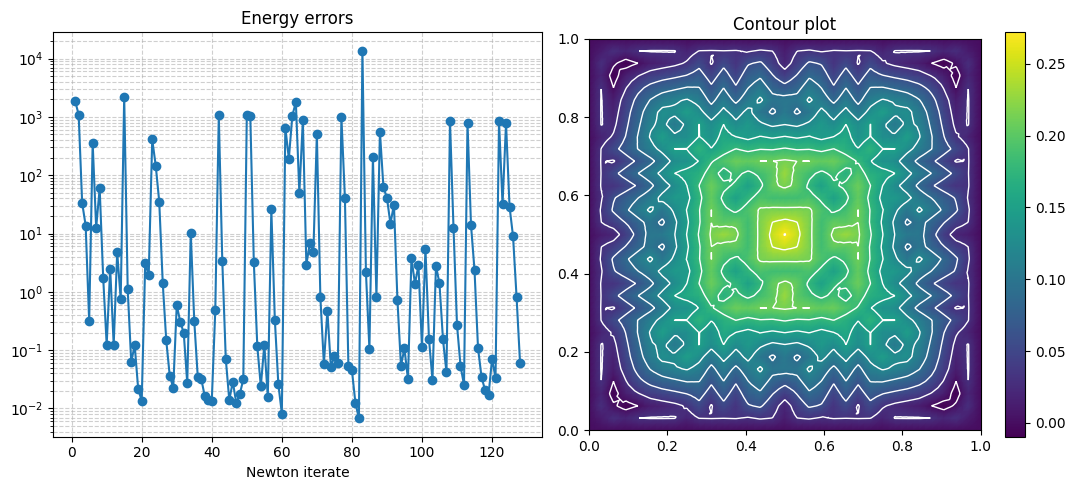

In [53]:
eikonal(nx=2**5, degree=1, gamma=2**9, max_iters=2**7, energy_exact=-0.020636295237596164)

2. Something we've all encountered:
Your initial guess might just lie **outside an attractive basin**.
This is especially common when you're looking at **highly nonlinear** problems with **multiple solutions**.

3. In Newton's method, the Jacobian, i.e. the linear operator we have to invert, changes at every iteration.
For instance, when minimising an energy functional, the Newton iterates are given by
$$
0 = E'(u_n; v) + E''(u_n; u_{n+1} - u_n, v).
$$
The Jacobian here is then $E''(u_n; \cdot, \cdot)$.

    **Assembly** can massively **dominate computation time**, so anything we can do to avoid repeated assembly of this Jacobian is welcome.
    This is especially true when you're at a high order, and you don't have so many tricks at your disposal to ensure this linear operator remains sparse.

Energy: 14.809210380965599
Newton iterate 1...
Energy: 711072.5454060978
Newton iterate 2...
Energy: 15.86075071061074
Newton iterate 3...
Energy: 0.4200185734332364
Newton iterate 4...
Energy: 0.012246345941764524
Newton iterate 5...
Energy: -0.008744347700662318
Newton iterate 6...
Energy: 6.63051302400383
Newton iterate 7...
Energy: 0.6195876317373284
Newton iterate 8...
Energy: 0.024355286807282352
Newton iterate 9...
Energy: -0.008190992063869293
Newton iterate 10...
Energy: -0.012303146558918085
Newton iterate 11...
Energy: 0.04564019249305608
Newton iterate 12...
Energy: -0.009367661461574504
Newton iterate 13...
Energy: -0.0010753997506234134
Newton iterate 14...
Energy: -0.01376168041412067
Newton iterate 15...
Energy: 15.708540176467478
Newton iterate 16...
Energy: 0.6150296571132976
Newton iterate 17...
Energy: -0.0008268088836631557
Newton iterate 18...
Energy: -0.01607455419663881
Newton iterate 19...
Energy: -0.019226161510900182
Newton iterate 20...
Energy: -0.0150523021

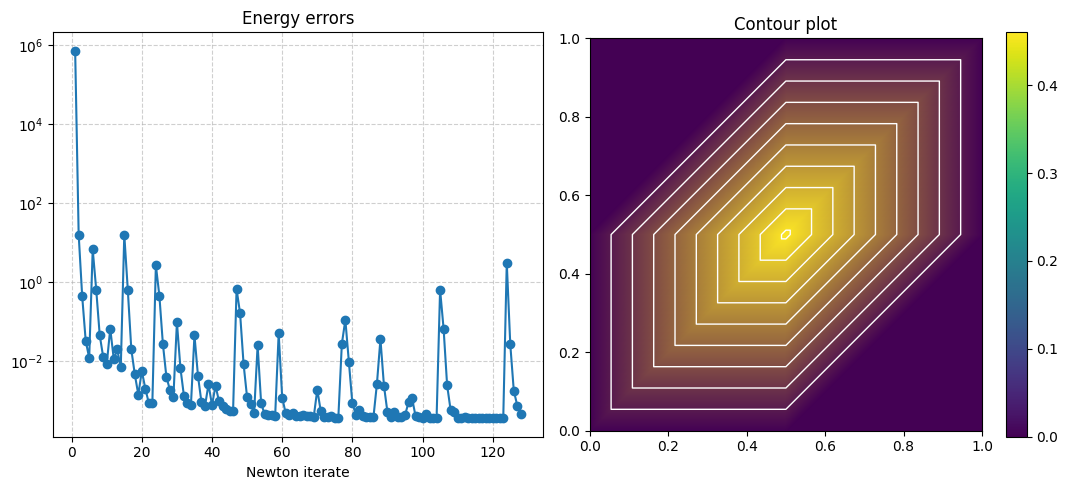

In [54]:
eikonal(nx=1, degree=20, gamma=2**9, max_iters=2**7, energy_exact=-0.020636295237596164)

(N.B. That contour plot only looks funny because the plotter can't handle high polynomial degrees.)

Let's discuss a pretty robust alternative then...

## **Back to basics:** Gradient descent (GD)

Let's restrict our attention to energy minimisation problems.
You might never have seen GD in the function space setting before, but the idea's identical.
Instead of the update
$$
\mathbf{x}_{n+1} = \mathbf{x}_n - h\nabla E(\mathbf{x}_n),
$$
we have
$$
(u_{n+1}, v) = (u_n, v) - hE'(\mathbf{x}_n; v).
$$

So how does it square up against Newton?
Well, the convergence rates are **bad** (more on this later) but there are a lot of pros:

1. You get convergence for $h \in (0, 2/L)$, where $L$ is the Lipschitz constant of $E'$, i.e. such that.
The immediate consequence of this is that we need **one lower level of regularity**, i.e. we need only assert that $E$ is Lipschitz differentiable, not *twice* Lipschitz differentiable as in Newton.

2. This **convergence is guaranteed**, no matter where you start.
No need to stress about multiple solutions and attractive basins, no matter how nonlinear your problem.

3. The inner product we need to invert is always the **canonical inner product on our function space**.
Much less to re-assemble every iteration, and much, much easier to invert efficiently at high order.

I'll repeat though:
The convergence rates are **so, so bad**.
In the general infinite-dimensional case (i.e. as we PDE folks are interested in)* the energy converges at a rate $\mathcal{O}(n^{-1})$;
specifically, taking $h = 1/L$ (i.e. the optimal choice in general),
$$
E(\mathbf{x}_n) - E_\text{min}  \le  \frac{\|\mathbf{x}_0 - \mathbf{x}_\text{min}\|^2L}{2} \cdot \frac{1}{n}.
$$

> **Specifically, the case without "strong convexity".*

Energy: 14.695419506632325
GD iterate 1...
Energy: 1.0217672758646792
GD iterate 2...
Energy: 0.19984542810265288
GD iterate 3...
Energy: 0.04911387759177009
GD iterate 4...
Energy: 0.00817108953425592
GD iterate 5...
Energy: -0.006086453497266464
GD iterate 6...
Energy: -0.011901311957600002
GD iterate 7...
Energy: -0.014551679994683838
GD iterate 8...
Energy: -0.01586892452631112
GD iterate 9...
Energy: -0.01656940449912389
GD iterate 10...
Energy: -0.016962491647666843
GD iterate 11...
Energy: -0.017193438183644622
GD iterate 12...
Energy: -0.01733480847420722
GD iterate 13...
Energy: -0.017424193118808908
GD iterate 14...
Energy: -0.01748240129700827
GD iterate 15...
Energy: -0.017521104466541308
GD iterate 16...
Energy: -0.017547444550368232
GD iterate 17...
Energy: -0.01756574702221986
GD iterate 18...
Energy: -0.01757869704546531
GD iterate 19...
Energy: -0.017588055694139605
GD iterate 20...
Energy: -0.01759493048721624
GD iterate 21...
Energy: -0.01760008060254322
GD iterate 2

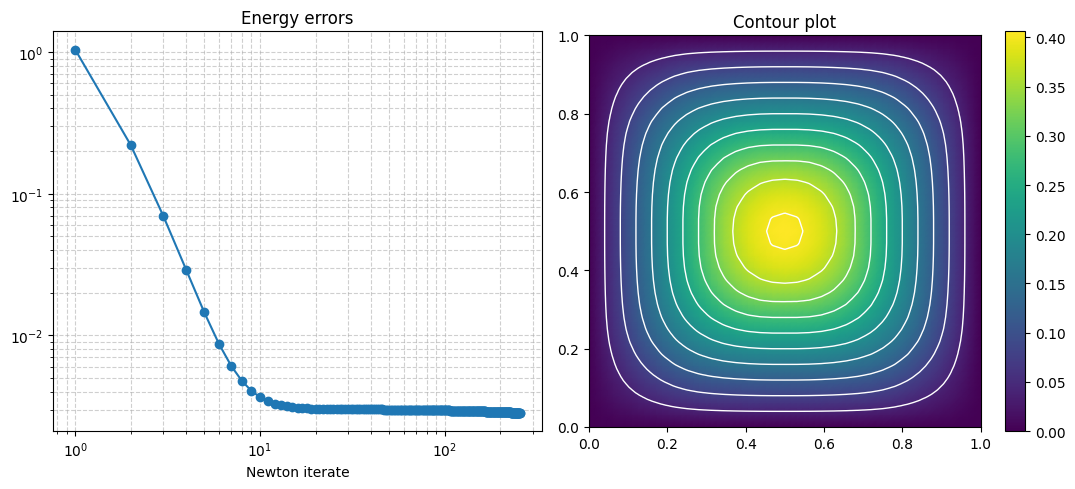

In [55]:
eikonal(nx=2**5, degree=1, gamma=2**9, max_iters=2**8, energy_exact=-0.020636295237596164, h=1.0)

The discrete solution captures the global behaviour well, but hasn't resolved the sharp edges we expect to see.
In particular, the contours aren't nearly as square as they should be.

(N.B. That's a log plot on the convergence plot's x axis now too.)

Let's investigate what's going on there with a little model problem...

## **2D demo**

Let's first check out that bound $h \in (0, 2L)$ on the step sizes.
We'll do this through GD on a super simple 2D quadratic function:
$$
E(x, y) := \frac{1}{2}x^2 + \frac{a}{2}y^2.
$$

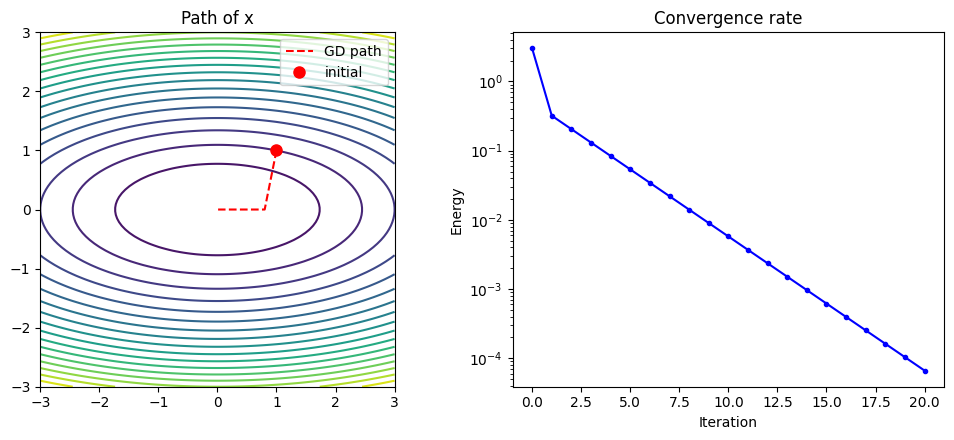

In [9]:
A = np.diag([1.0, 5.0])
gd_quad_plot2D(A=A, h=1.0)

Playing around with $h$, we see that, as expected, **step sizes outside** $(0, 2L)$ **break convergence**;

N.B. Don't be deceived by the exponential convergence you see here; this is expected in the finite dimensional case, for $n \ge d$.

In general, the path of the solution rushes to **resolve the steepest gradients in $E$ first**, then ***sloooooowly* makes its way up the shallow gradients**.
This corresponds with that "shrinkwrap" behaviour we saw in the obstacle problem!
The steepest gradients in $E$ there are associated with the large $\lambda \int_{u < f}(u - f)^2$;
it resolved those (i.e. lifts $u \ge f$) then *sloooooowly* resolves the remaining $\int \|\nabla u\|^2$ term everywhere else.

So, how might we speed this up?
We could try tweaking $h$ to get the fastest convergence rate possible...

*...but first, let's run **linesearch**, to get some idea maybe of what rate we should pick:*

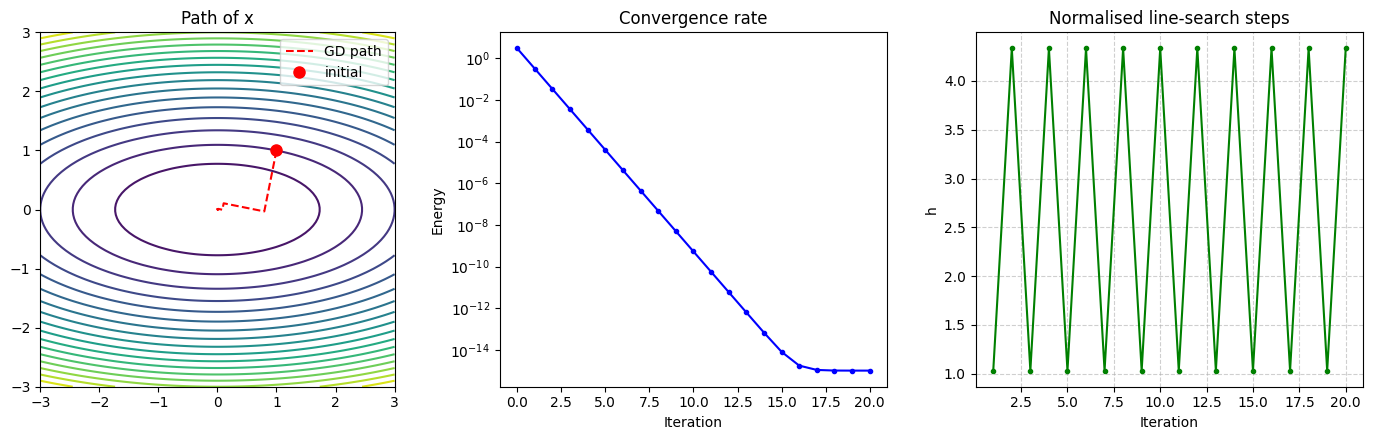

In [10]:
gd_quad_plot2D(A=A, h="linesearch")

Oh, that's interesting...

*...linesearch isn't taking uniform step sizes, but **alternating** between a **small one** and a **large one**.*

The small steps take you up the steep gradients, up to that centre manifold (the x axis) then the large ones hurry us along there.
In fact, these large step sizes are **so large** that it would normally be forbidden (i.e. much greater than $2/L$)!
This gives us an idea:

> *If we use **periodic patterns of step sizes**, we can accelerate the convergence!*

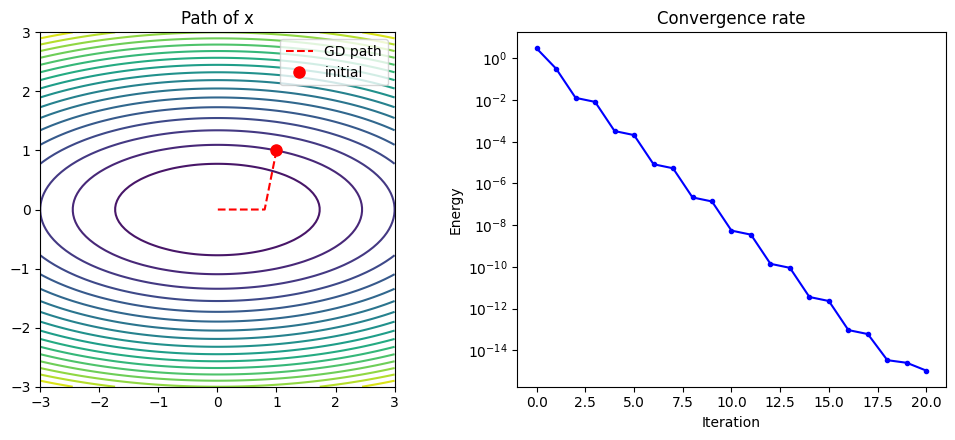

In [11]:
gd_quad_plot2D(A=A, h=np.array([1.0, 4.0]))

An immediate appeal of this is that we don't have to keep doing the potentially costly linesearch process, which involves many function evaluations.
It gets better than that though...

## **ND demo:** Grimmer, 2024

Let's up the dimension a little.
We'll use a **random PSD** $A \in \mathbb{R}^{1024 \times 1024}$, and define
$$
E(\mathbf{x})  =  \frac{1}{2} \mathbf{x}^\top A \mathbf{x}.
$$

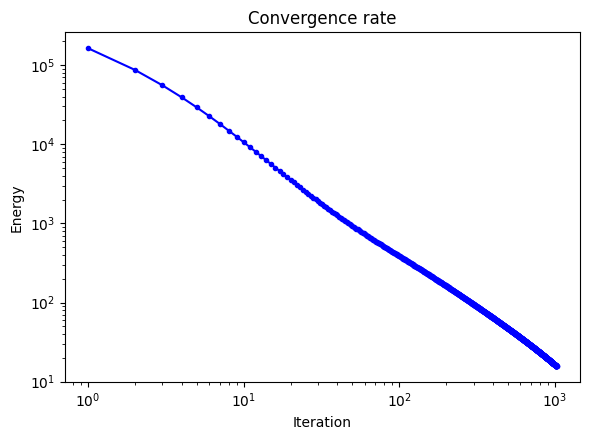

In [12]:
dim = 2**10
M = np.random.randn(dim, dim)
A = M.T @ M
gd_quad_plotND(A=A, h=1.0, n_steps=2**10)

At long last!
We reach the literature portion of this reading group...

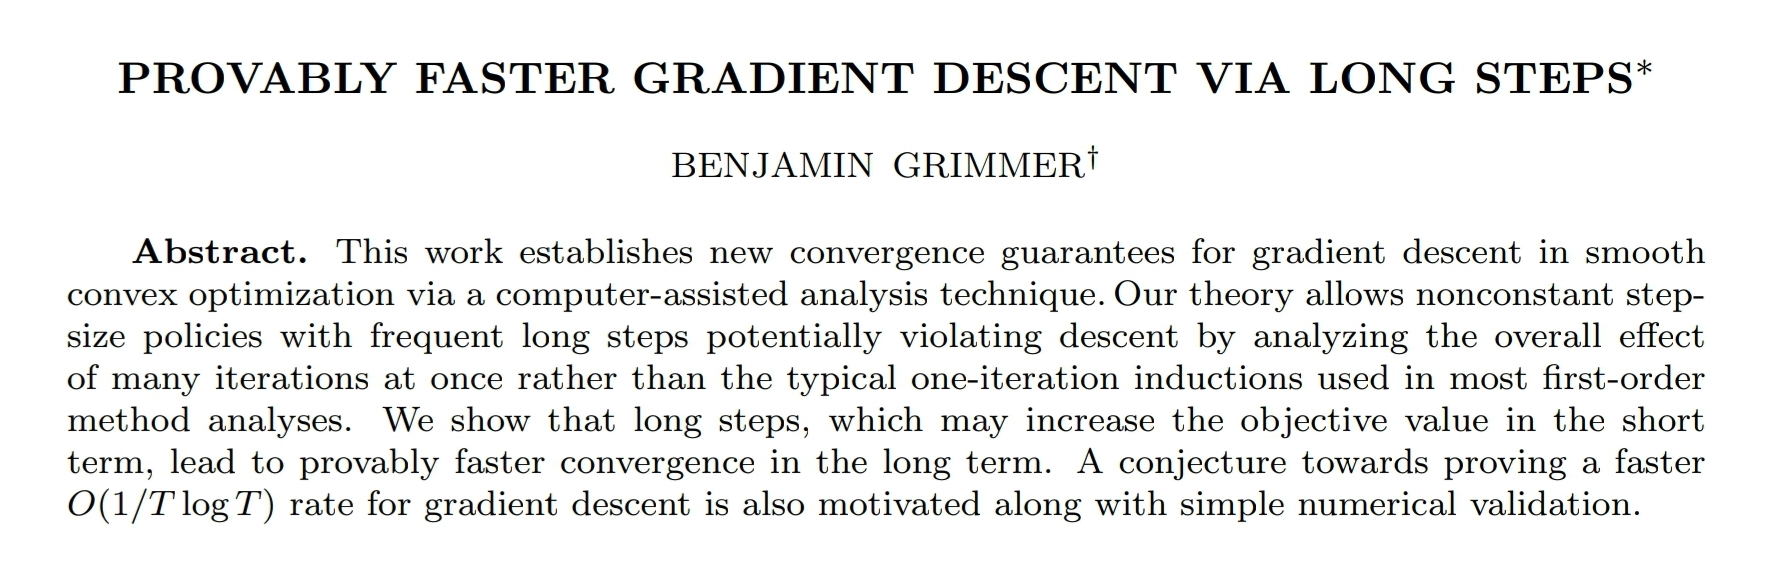

Last year, Grimmer defined various **periodic cycles** of **step sizes** that leverage this idea we saw from the model 2D demo above.
For each of these, he was able to prove they **retain** the **guaranteed convergence** of GD,* although now with faster convergence rates.

For example, while traditional GD always taking $h = 1/L$ has converge rates
$$
E(\mathbf{x}_n) - E_\text{min}  \le  \frac{\|\mathbf{x}_0 - \mathbf{x}_\text{min}\|^2L}{2} \cdot \frac{1}{n},
$$
he shows that cycling $h$ through $(1.5, 4.9, 1.5)/L$, this rate is improved by a constant factor:
$$
E(\mathbf{x}_n) - E_\text{min}  \le  \frac{\|\mathbf{x}_0 - \mathbf{x}_\text{min}\|^2L}{2} \cdot \frac{1}{2.63333... \cdot n}.
$$

> **The proof of this is pretty heavy-duty, and very optimisation-vibes, so I won't detail it here.*

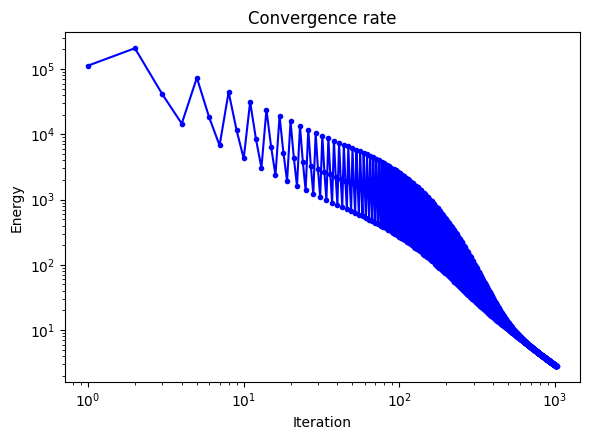

In [13]:
gd_quad_plotND(A=A, h=(1.5, 4.9, 1.5), n_steps=2**10)

A constant factor might not seem like much, but when you're talking about GD, that's a big deal.

Interesting, we can see these long steps sometimes cause a **temporary increase in the objective function**, with the benefit of faster convergence in the long run.

The cycles he finds are all of length $2^k - 1$, from length $3$ up to $127$:

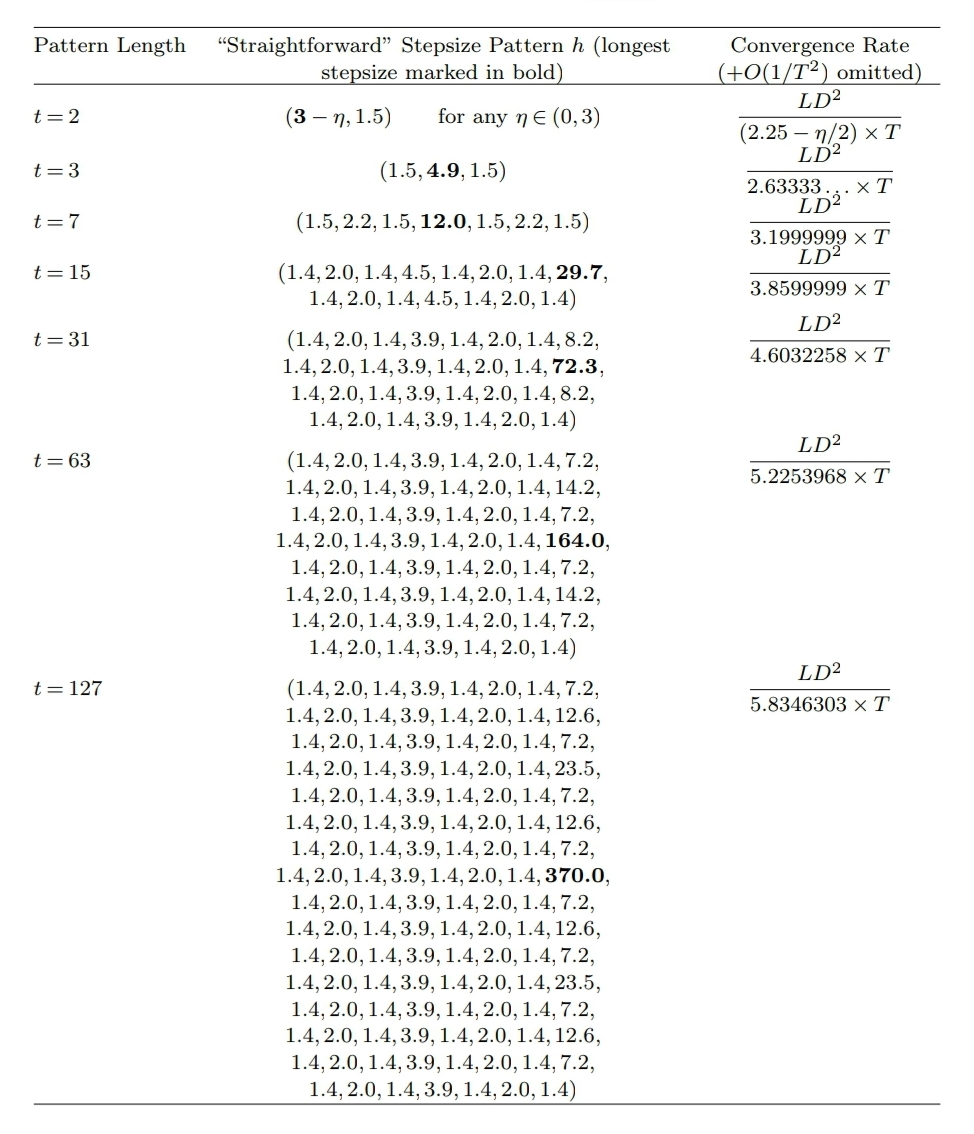

These patterns have a very curious behaviour.
Each step-size cycle of length $2^k - 1$ is obtained by concatenating:
$$
\text{length-$(2^{k-1} - 1)$ cycle} \quad \text{–} \quad \text{long step}_k  \quad \text{–} \quad \text{length-$(2^{k-1} - 1)$ cycle}
$$
I've found it pretty hard to describe this pattern*, but it's pretty obvious what I mean when you look at the numbers.

Here's how the length-$127$ cycle behaves, offering a speed-up of $\sim\!5.8$:

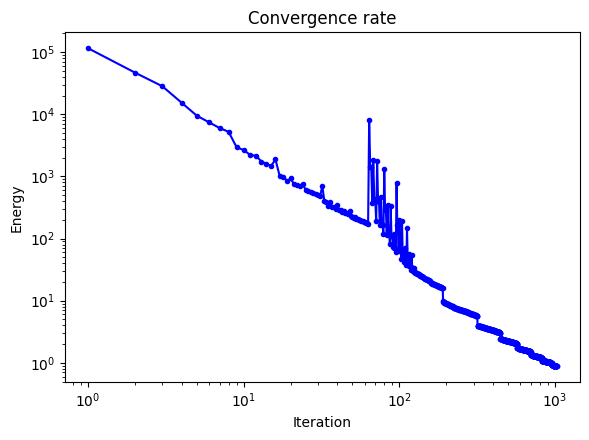

In [14]:
gd_quad_plotND(A=A, h=(1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,23.5,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,370.0,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,23.5,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4), n_steps=2**10)

I'd just like to highlight how **massive** that long step is.
We're taking, at the peak, $h = 370/L$, when previously I said we couldn't take $h \ge 2/L$ without breaking convergence!

We can see this does a lot better than linesearch too:

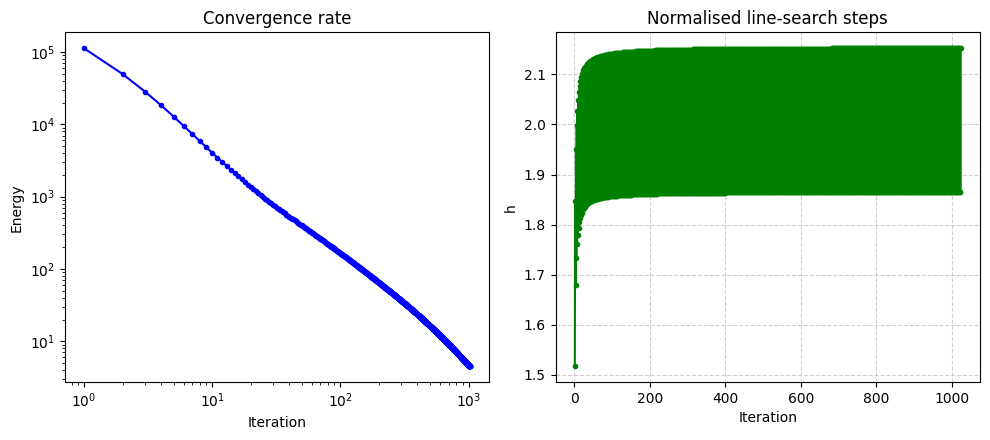

In [15]:
gd_quad_plotND(A=A, h="linesearch", n_steps=2**10)

So let's take this back to the eikonal equation from earlier...

## **The eikonal equation**: Revisited

To recap: When applied to the model 2D problem, we saw GD was quick to resolve the large $5y^2$ term, but slow to resolve the small $x^2$ term.
The issue in $N$ dimensions is the same: GD resolves the largest eigenvalues of $A$, but is held up on its smallest eigenvalues.

This aligns with the behaviour we saw for GD in the PDE setting!
Above, when applied to the eikonal equation, GD very quickly resolved the global behaviour, but was held up in resolving the fine-scale behaviour on the crests and ridges.
So, let's try out those periodic patterns...

Energy: 14.695419506632325
GD iterate 1, step size 1.4...
Energy: 0.020650908960179834
GD iterate 2, step size 2.0...
Energy: -0.011918484968687382
GD iterate 3, step size 1.4...
Energy: -0.015856850068688397
GD iterate 4, step size 3.9...
Energy: -0.017347827749127204
GD iterate 5, step size 1.4...
Energy: -0.017369625488088052
GD iterate 6, step size 2.0...
Energy: -0.017384394255753697
GD iterate 7, step size 1.4...
Energy: -0.01739012722708848
GD iterate 8, step size 7.2...
Energy: -0.017404686070561656
GD iterate 9, step size 1.4...
Energy: -0.017406027315328133
GD iterate 10, step size 2.0...
Energy: -0.017407882187985065
GD iterate 11, step size 1.4...
Energy: -0.017409152462698595
GD iterate 12, step size 3.9...
Energy: -0.017412649864647328
GD iterate 13, step size 1.4...
Energy: -0.01741389076649032
GD iterate 14, step size 2.0...
Energy: -0.017415659012638533
GD iterate 15, step size 1.4...
Energy: -0.017416893752568923
GD iterate 16, step size 12.6...
Energy: -0.01742796431

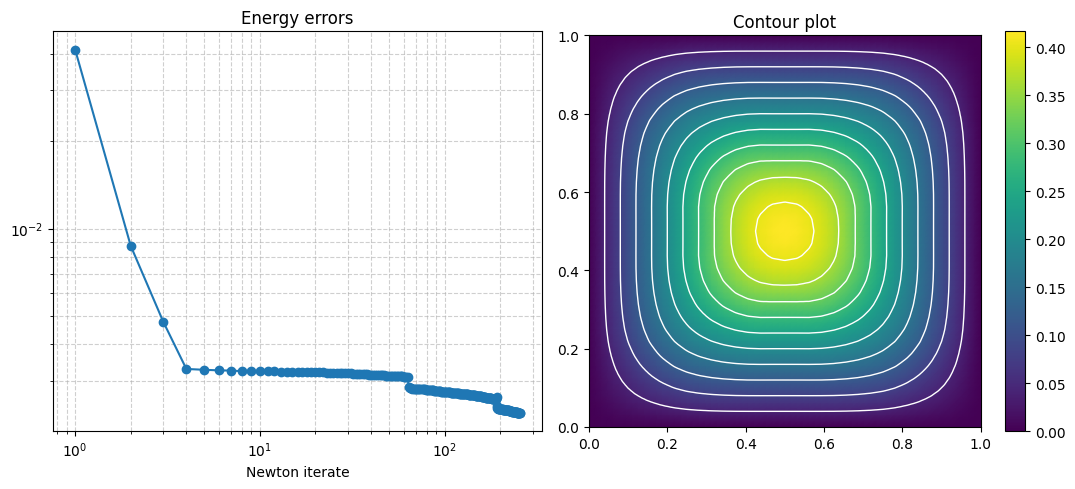

In [56]:
eikonal(nx=2**5, degree=1, gamma=2**9, max_iters=2**8, energy_exact=-0.020636295237596164, h=(1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,23.5,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,370.0,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,23.5,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4))

Well, we can see the boost we got from the big step, but it's not exactly game-changing.

We're going to need something with a bit more power...

## **Convergence rate optimisation:** Zhigljavsky, Pronzato & Bukina, 2013

If we relax the requirement that the scheme is gauranteed to converge,* we can speed up the convergence by a factor of $n$.

> **Something that I'm sure won't come back to bite us in the future...*

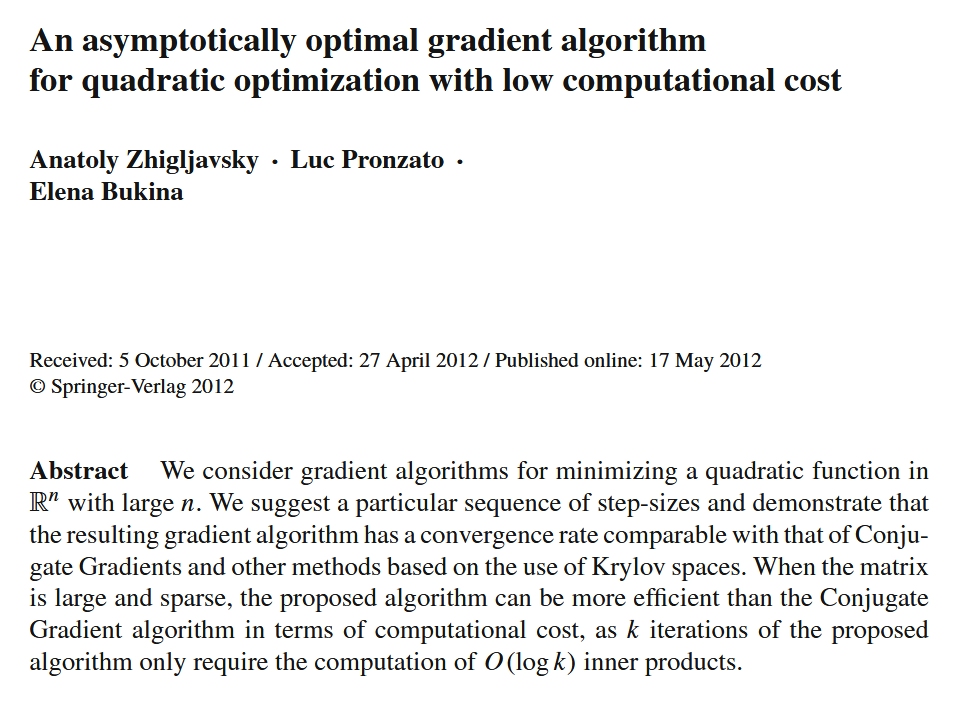

In 2013, Zhigljavsky, Pronzato and Bukina considered **quadratic optimisation** problems, like those we had earlier for our $N$-dimensional demo,
$$
E(\mathbf{x})  =  \frac{1}{2} \mathbf{x}^\top A \mathbf{x},
$$
with SPD $A$.
The analysis of different step cycles in the quadratic case is *soooooo* much easier;
in fact, it's essentially the same as the analysis of CG.

Since $\nabla E(\mathbf{x}) = A\mathbf{x}$, each iterate here evaluates as
$$
\mathbf{x}_n  =  \mathbf{x}_{n-1} - h_n\nabla E(\mathbf{x}_{n-1})  =  \mathbf{x}_{n-1} - h_nA\mathbf{x}_{n-1}  =  (I - h_nA)\mathbf{x}_{n-1}.
$$
We find $\mathbf{x}_n$ then by induction as
$$
\mathbf{x}_n  =  p_n(A)\mathbf{x}_0,
$$
where $p_n$ is the degree-$n$ polynomial
$$
p_n(s) = (1 - h_1s)\cdots(1 - h_ns).
$$
The energy at the $n$-th iteration evaluates as
$$
E(\mathbf{x}_n)  =  \frac{1}{2}\mathbf{x}_n^\top A \mathbf{x}_n  =  \frac{1}{2}\mathbf{x}_0^\top p_n(A)Ap_n(A) \mathbf{x}_0  \le  \frac{1}{2}\|\mathbf{x}_0\|^2 \|p_n(A)^2A\|_2  =  \frac{1}{2}\|\mathbf{x}_0\|^2 \sup_{\text{eigvals. }\lambda\text{ of }A}\|p_n(\lambda)^2\lambda\|.
$$
The quest is then the following:

> **Find a sequence of** $(h_n)$ **such that** $|p_n(\lambda)^2\lambda| \to 0$ **on the spectrum of** $A$ **as quickly as possible.**

The authors propose the following crazy identity:
$$
h_n  =  \frac{1}{\|A\|_2}\cdot\frac{1}{\sin(\phi\pi n)^2},
$$
where $\phi = \frac{1 + \sqrt{5}}{2}$ is the golden ratio.
The associated polynomials $p_n$ satisfy the following:
* **Uniform boundedness** (by $1$) on $[0, \|A\|_2]$ (see $p_{144}$ below)

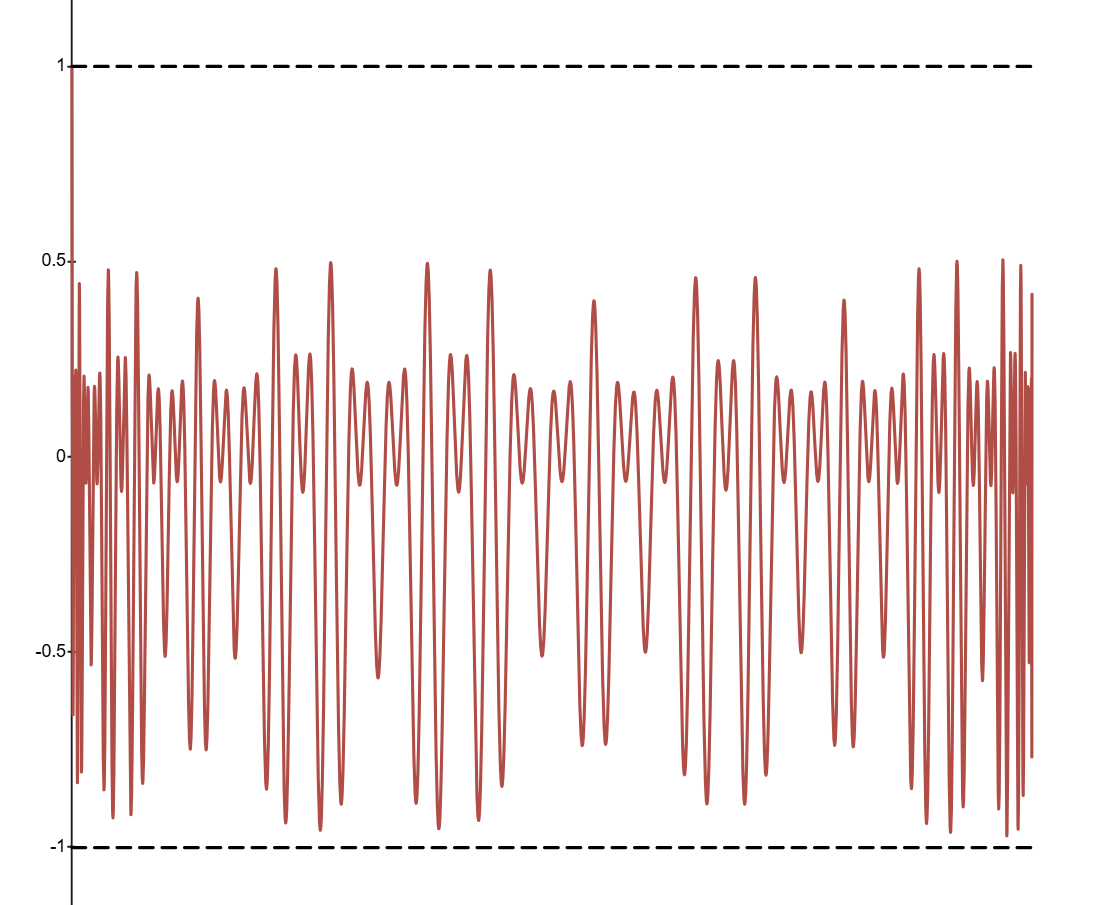

* An **asymptotic bound** $\sup_{\lambda \in [0, \|A\|_2]}|p_n(\lambda)^2\lambda| = \mathcal{O}\!\left(\frac{1}{n^2}\!\right)$ whenever $n$ is $1$ less than a Fibonacci number (see $p_{143}$ below)

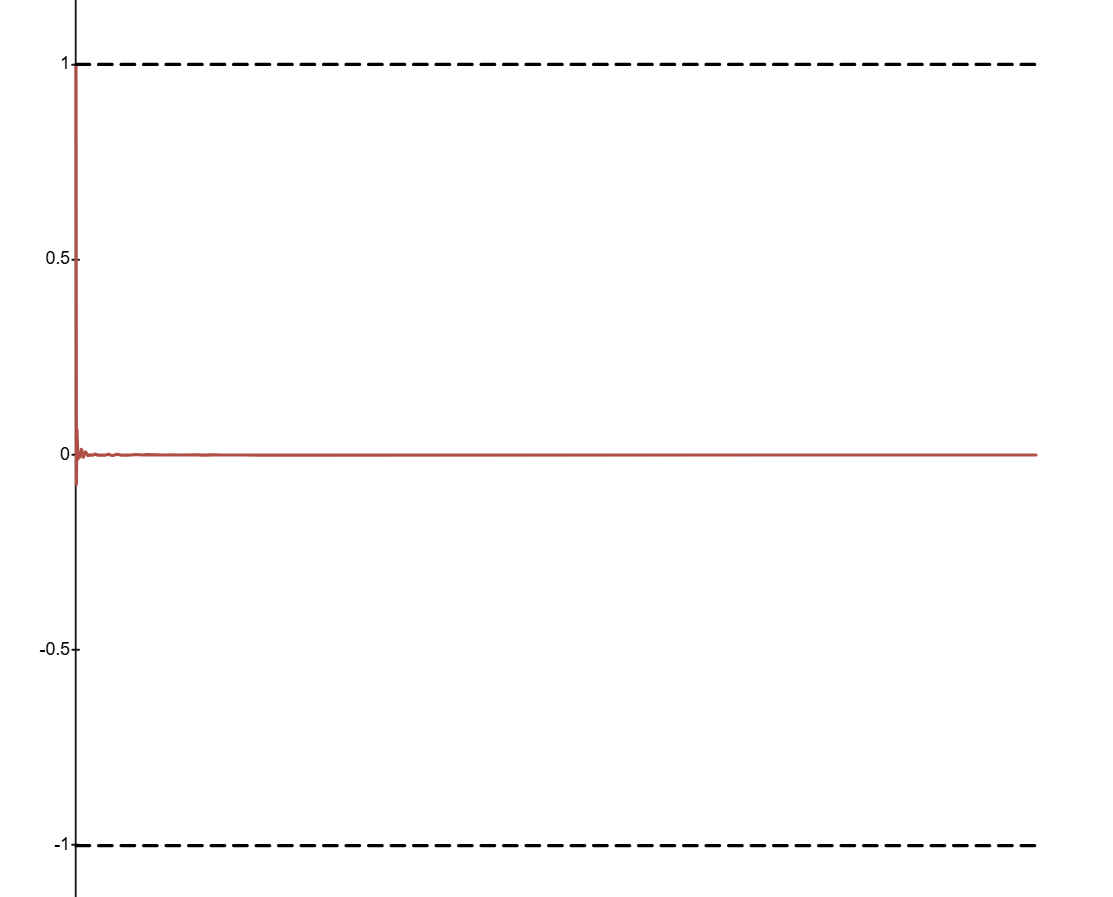

Let's see it in action!
So, this was the length-127 cycle from earlier...

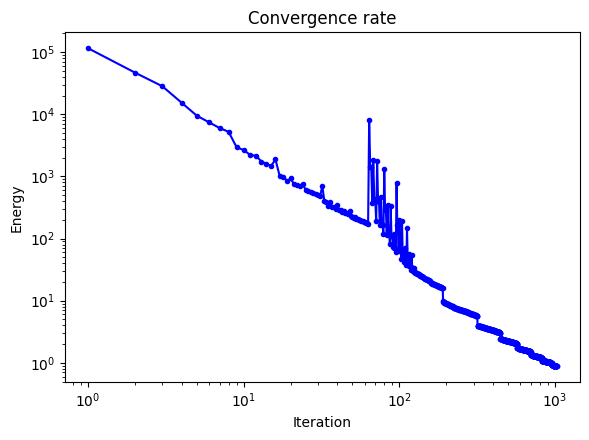

In [58]:
gd_quad_plotND(A=A, h=(1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,23.5,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,370.0,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,23.5,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4), n_steps=2**10)

And here's the newly proposed formula...

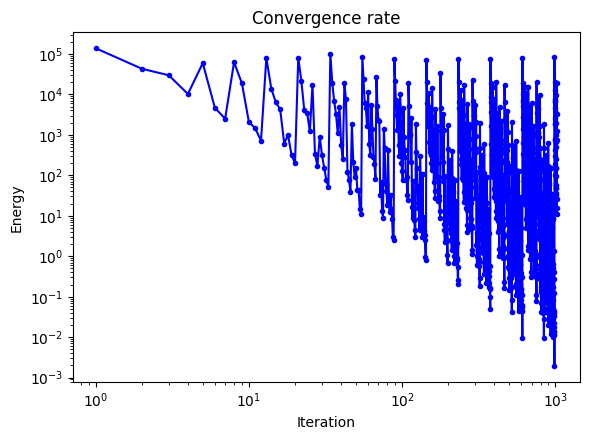

In [59]:
phi = (1 + sqrt(5))/2
gd_quad_plotND(A=A, h=[1/sin(phi*pi*(i+1))**2 for i in range(2**10)], n_steps=2**10)